# Train Caption-en model

Goal: Extract data information from caption labels

1. Classify opening and closing parentheses and others

2. Classify letters that appear in Month description and digits

Note: We include 't' as a possible letter to avoid confusion due to 'through' 


In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

Using Theano backend.


In [2]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [3]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [4]:
X = np.load(os.path.join(datadir, 'X-en.npy'))
Y = np.load(os.path.join(datadir, 'Y-en.npy'))

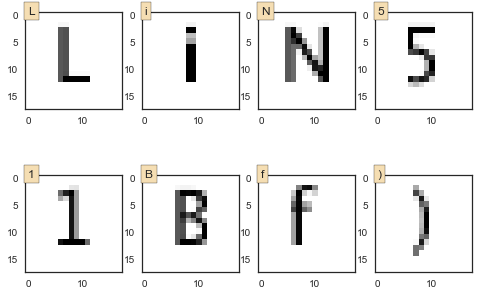

In [5]:
# convenient functions
def random_plot(X, Y, predicted=None):
    if len(Y) < 1: return
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))

def ngram(x, n):
    out = set()
    for i in range(len(x)-n+1):
        item = x[i:(i+n)]
        if type(x) == str:
            out.add(item)
        else:
            out.add(tuple(item))
    return out 


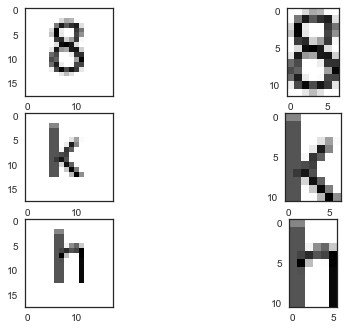

In [6]:
# remove background
def remove_background(x, bg = 1.0):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    tmp = non_bg_rows.nonzero()[0]
    if len(tmp) == 0: return None
    i1 = tmp[0]
    i2 = tmp[-1] + 1
    
    tmp = non_bg_cols.nonzero()[0]
    if len(tmp) == 0: return None
    j1 = tmp[0]
    j2 = tmp[-1] + 1
    
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x) for x in X]
compare_plot(X, X_nobg)

## Train parentheses classifier

In [7]:
# obtain size of parenthesis images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[\(\)]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

13 12
target_shape (17, 16)


total: 62, included: 62, out: 0
non-included samples
included samples


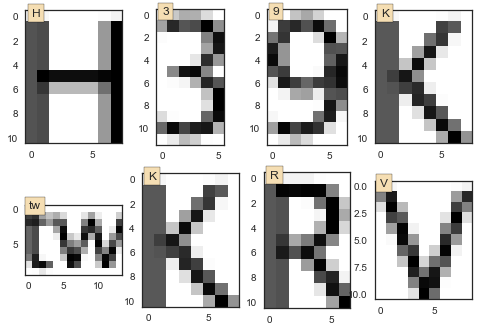

In [8]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X1 = X_in
Y1 = Y_in

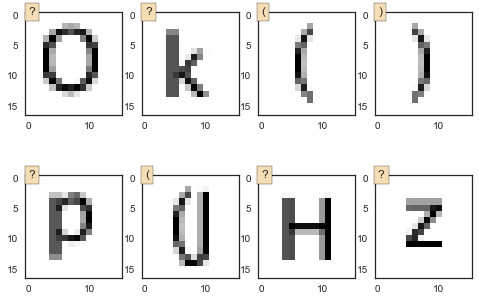

?    57
(     4
)     1
dtype: int64

In [9]:
X1 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X1]
X1 = [np.expand_dims(x, axis=0) for x in X1]
X1 = np.vstack(X1)

for i in range(len(Y1)):
    if Y1[i].find('(') >= 0:
        Y1[i] = '('
    elif Y1[i].find(')') >= 0:
        Y1[i] = ')'
    else:
        Y1[i] = '?'
Y1 = np.array(Y1)

random_plot(X1, Y1)
pd.Series(Y1).value_counts()

In [10]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X1, Y1, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X1, Y1, 5000, seed = 7)

In [11]:
# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}


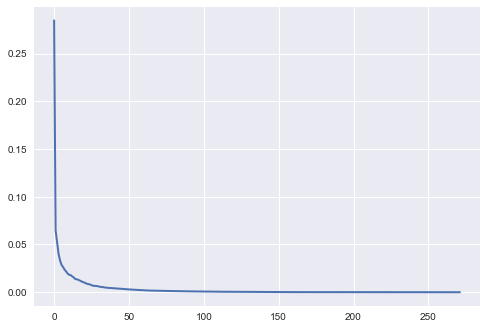

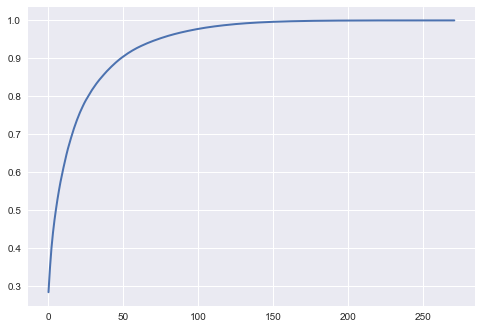

1 0.284731144549
2 0.349330838798
3 0.401408323962
4 0.441351814083
5 0.474426435894
6 0.502980511493
7 0.529244621824
8 0.55284840981
9 0.574632467057
10 0.594218271233
11 0.612464238036
12 0.630414526901
13 0.647060628765
14 0.662708463176
15 0.676652067264
16 0.690203066981
17 0.703322868866
18 0.715650470101
19 0.727093063857
20 0.737889024107
21 0.74810786814
22 0.757708114582
23 0.766443242888
24 0.7749099895
25 0.782977474114
26 0.790332277337
27 0.797053251069
28 0.803744256127
29 0.810285098193
30 0.816649953248
31 0.822500146063
32 0.828175307151
33 0.833700464643
34 0.838934298137
35 0.84384344474
36 0.848571760475
37 0.853148444483
38 0.85763454739
39 0.862093830887
40 0.866406887135
41 0.870510348161
42 0.874511054932
43 0.878357127609
44 0.882148715135
45 0.885837669837
46 0.889366973359
47 0.892809285657
48 0.896071820753
49 0.899242576971
50 0.902273234302
51 0.905139891958
52 0.907971237631
53 0.910703791379
54 0.913379808372
55 0.915914230259
56 0.918386556082
57 0.92

In [12]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


100 to 150

accuracy on original set =  1.0
accuracy =  0.991911324146


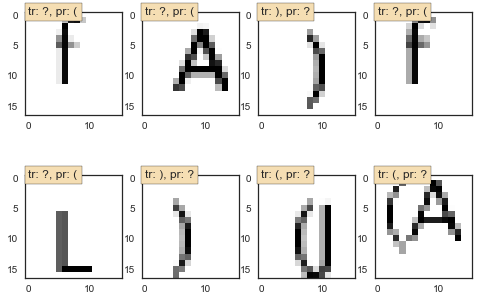

col_0    (    )     ?    All
row_0                       
(      600    0    45    645
)        0  145    17    162
?       18    1  9188   9207
All    618  146  9250  10014


In [13]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X1, Y1))
diagnosis(pipe_mlp, X_test, Y_test)

In [14]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X1, Y1, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X1, Y1)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.919213101658 score on original = 0.91935483871
103424 score on test = 0.999400838826 score on original = 1.0
DONE!


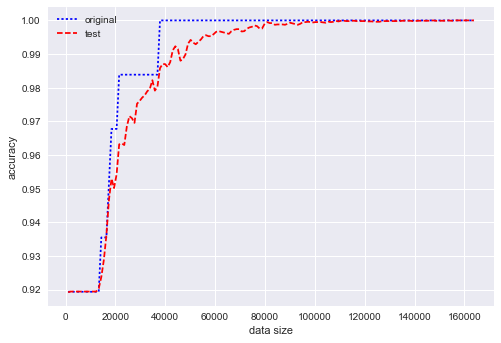

In [15]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [16]:
savename = os.path.join(modeldir, 'caption-en-paren_pca-mlp-full.pkl')
pipe = ([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-en-paren_pca-mlp-full.pkl']

In [17]:
with open(os.path.join(modeldir, 'caption-en-paren-config.json'), 'w') as file:
    json.dump(dict(input_shape=X1.shape[1:]), file)

## Classification of date-relevant letters

In [18]:
# obtain size of date relevant images images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[JanFebMarAprMayJunJulIAugSepOctNovDec0-9\(\),t]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

13 14
target_shape (17, 18)


total: 62, included: 62, out: 0
non-included samples
included samples


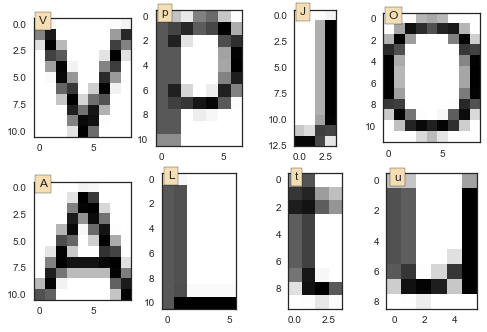

In [19]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X2 = X_in
Y2 = Y_in

J, a, n, e, F, b, a, r, M, p, r, A, a, y, M, J, n, u, J, l, u, J, I, u, g, u, A, e, p, S, O, c, t, v, N, o, e, c, D, an, Ja, eb, Fe, ar, Ma, Ap, pr, Ma, ay, Ju, un, Ju, ul, Ju, uI, ug, Au, Se, ep, ct, Oc, No, ov, De, ec, (J, (F, (M, (A, (M, (J, (J, (J, (A, (S, (O, (N, (D, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, (, ), ,, t, th


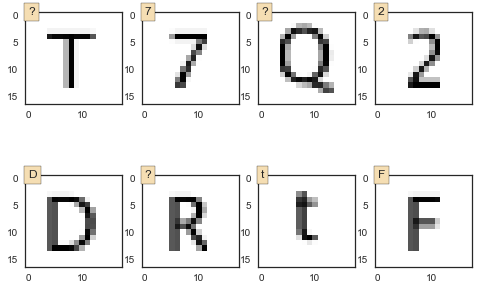

?     23
(J     2
,      1
M      1
r      1
(A     1
y      1
F      1
v      1
c      1
e      1
I      1
u      1
O      1
a      1
3      1
n      1
J      1
ov     1
)      1
6      1
4      1
9      1
t      1
(      1
0      1
N      1
D      1
7      1
o      1
8      1
b      1
S      1
p      1
1      1
5      1
A      1
g      1
2      1
dtype: int64

In [20]:
X2 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X2]
X2 = [np.expand_dims(x, axis=0) for x in X2]
X2 = np.vstack(X2)


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'JuI', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month1 = sum([list(ngram(x, 1)) for x in month_names], [])
month2 = sum([list(ngram(x, 2)) for x in month_names], [])
month3 = ['(' + x[0] for x in month_names]
dig_sym = [s for s in '0123456789(),']

date_relevant = month1 + month2 + month3 + dig_sym + ['t', 'th']
print(', '.join(date_relevant))

Y2 = [y if y in date_relevant else '?' for y in Y2]
Y2 = np.array(Y2)

random_plot(X2, Y2)
pd.Series(Y2).value_counts()

In [21]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X2, Y2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X2, Y2, 5000, seed = 7)

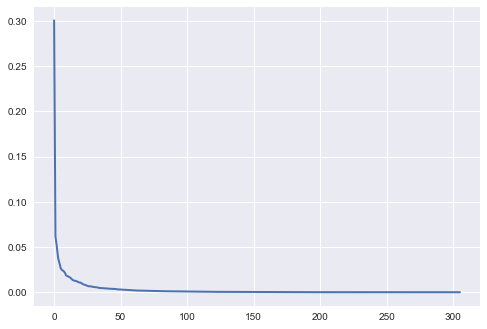

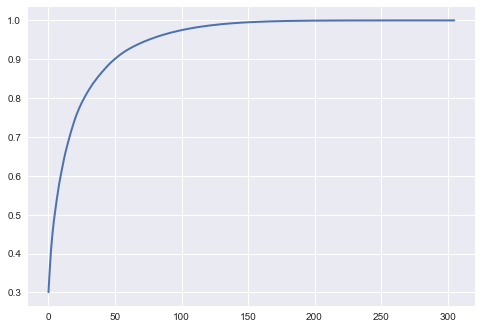

1 0.300438685333
2 0.362179704671
3 0.412988307981
4 0.450788106336
5 0.483044249654
6 0.509379152768
7 0.533822296598
8 0.557244628892
9 0.579089990965
10 0.597675414264
11 0.615510953785
12 0.632592719732
13 0.648869541214
14 0.663700549608
15 0.677180657067
16 0.689997671663
17 0.702547174028
18 0.71463237092
19 0.725954648659
20 0.736668661946
21 0.74720886743
22 0.756702596187
23 0.7653203277
24 0.773477578316
25 0.781210507222
26 0.788259452682
27 0.794834917872
28 0.801292670921
29 0.807649927423
30 0.813615724015
31 0.819355870523
32 0.824862270067
33 0.830255366636
34 0.835432898906
35 0.840125619657
36 0.844763307349
37 0.849318357502
38 0.853726339552
39 0.858007754951
40 0.86217521414
41 0.866190032942
42 0.870164549696
43 0.874014817532
44 0.877842513783
45 0.881530444765
46 0.885178161032
47 0.888711399516
48 0.891977029268
49 0.895089264961
50 0.898180566787
51 0.9011657372
52 0.903980755747
53 0.906726950604
54 0.909432878355
55 0.912017256188
56 0.91452847316
57 0.9169

In [22]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


accuracy on original set =  1.0
accuracy =  0.961653684841


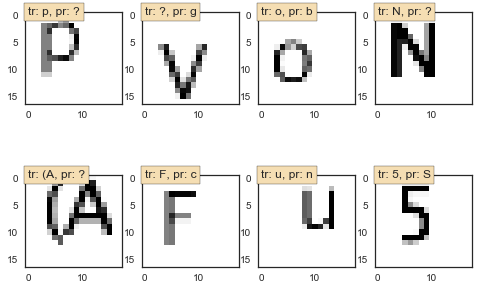

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      152    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  148    0    0    0    0    0    0    0    0  ...      0    0    2   
(J       0    0  311    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  157    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  157    0    0    0    0    0  ...      0    0    0   
0        0    0    0    0    0  154    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  152    0    6    0  ...      0    0    0   
2        0    0    0    0    0    0    0  155    2    0  ...      0    0    0   
3        0    0    2    0    0    0    3    0  149    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  154  ...      0    0    0   
5        0    0    0    0   

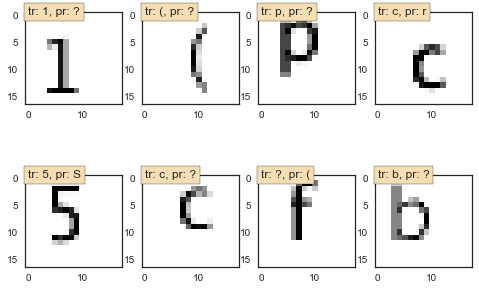

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      152    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  148    0    0    0    0    0    0    0    0  ...      0    0    2   
(J       0    0  311    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  157    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  157    0    0    0    0    0  ...      0    0    0   
0        0    0    0    0    0  154    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  152    0    6    0  ...      0    0    0   
2        0    0    0    0    0    0    0  155    2    0  ...      0    0    0   
3        0    0    2    0    0    0    3    0  149    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  154  ...      0    0    0   
5        0    0    0    0   

In [23]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X2, Y2))
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_test, Y_test)

In [24]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_


num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X2, Y2, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X2, Y2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.371380067905 score on original = 0.370967741935
103424 score on test = 0.966546834432 score on original = 1.0
205824 score on test = 0.995006990214 score on original = 1.0
308224 score on test = 0.999001398043 score on original = 1.0
410624 score on test = 0.999900139804 score on original = 1.0
DONE!


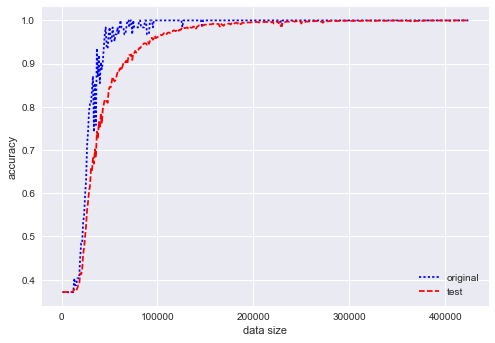

In [25]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [26]:
savename = os.path.join(modeldir, 'caption-en-letter_pca-mlp-full.pkl')
pipe = ([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-en-letter_pca-mlp-full.pkl']

In [27]:
with open(os.path.join(modeldir, 'caption-en-letter-config.json'), 'w') as file:
    json.dump(dict(input_shape=X2.shape[1:]), file)